### Sentiment Analyse 
#### Ausgangslage
In einem Online Shop können Produkte Reviews in Form von Text geschrieben werden. Wir möchten herausfinden ob der Text positiv oder negativ ist und so die Bewertung für das Produkt erstellen zu können.

#### Aufgabe
Anhand von Produkten von Amazon wollen wir den Sentiment für die Produkte berechnen. Dies tun wir mittels Textanalyse und Supervised Learning Algorithmen wie MaxEnt oder Naive Bayes.

In [46]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk
from IPython.core.display import HTML

#### Laden der Produkt Daten

In [2]:
csv_data = pd.read_csv(r"1429_1.csv")
csv_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


#### Daten für die Sentiment Analyse extrahieren und null values analyse

In [3]:
data = csv_data[['reviews.rating' , 'reviews.text' , 'reviews.title' , 'reviews.username']]
print(data.isnull().sum())
data.head()

reviews.rating      33
reviews.text         1
reviews.title        5
reviews.username     2
dtype: int64


,reviews.rating,reviews.text,reviews.title,reviews.username
0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter
1,5.0,great for beginner or experienced person. Boug...,very fast,truman
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42


#### Sentiment anhand des Ratings setzen
Alle Produkte die ein Rating von 4 und grösser haben sind positiv.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


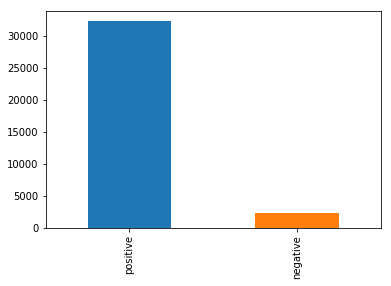

In [4]:
# Wieder Enfernen, wird vom Teilnehmer gemacht
data["sentiment_rating"] = data["reviews.rating"] >= 4
data["sentiment_rating"] = data["sentiment_rating"].replace([True , False] , ["positive" , "negative"])
data["sentiment_rating"].value_counts().plot.bar()

#### Text für die Sentiment Analyse vorbereiten

In [7]:
cleanup_re = re.compile('[^a-z]+')
def cleanup_text(sentence):
    # Wieder löschen, müssen die Teilnehmer coden.
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

In [8]:
sentiment = data[data["reviews.text"].notnull()]
sentiment["text_clean"] = sentiment["reviews.text"].apply(cleanup_text)
sentiment.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment_rating,text_clean
0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,positive,this product so far has not disappointed my ch...
1,5.0,great for beginner or experienced person. Boug...,very fast,truman,positive,great for beginner or experienced person bough...
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ,positive,inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks,positive,i ve had my fire hd two weeks now and i love i...
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42,positive,i bought this for my grand daughter when she c...


#### Implementation der Sentiment Analyse mittels NLTK

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oh0155\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
def set_sentiment(text):
    score = sentiment_analyzer.polarity_scores(text)
    if score["compound"] == 0.0: 
        return "neutral"
    elif score["compound"] > 0.0:
        return "positive"
    else:
        return "negative"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


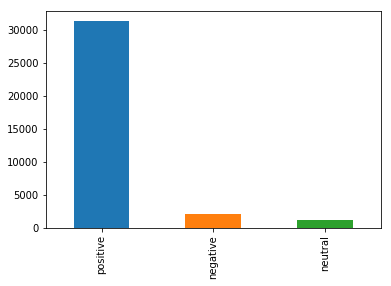

In [15]:
sentiment["sentiment_text"] = sentiment["text_clean"].apply(set_sentiment)
sentiment.head()
sentiment["sentiment_text"].value_counts().plot.bar()

#### Ausgabe der negativen Kommentare

In [55]:
negative_summary = list()
for k, v in sentiment.iterrows():
    if v["sentiment_text"] == "negative":
        negative_summary.append({"text": v["text_clean"], "sentiment": v["sentiment_text"]})
        
pd.set_option('display.max_colwidth', -1)      
pd.DataFrame(negative_summary).head(50)

,sentiment,text
0,negative,not easy for elderly users cease of ads that pop up
1,negative,i really like this tablet i would have given stars but sometimes you have to push start several times after you unlock the screen and it is a little annoying
2,negative,this fire tablet has long battery life reasonable fast
3,negative,i am very happy with this tablet the worst thing is that my steals it all the time lol
4,negative,a family member has vision problems they had seen used the kindle of another family member especially the ability to scale text this device will make it possible to read which she has had extreme difficulty doing
5,negative,i bought this because i was tired of watching youtube and twitch on my phone excellent display sound is decent not great but you can always buy a speaker the negatives are it is definitely a fingerprint magnet and the spectrum tv app is awful the app works fine on my phone but for some reason on this tablet it freezes and is unusable all things considered for bucks it s hard to be beat
6,negative,works as we thought it should no problems good buying experience
7,negative,my yr old daughter got this tablet from santa for christmas so far she loves it a little too much perhaps i only use it to manage her account permissions and so far haven t had any issues with it software and hw not quite as refined as apple ipad products but what can you expect at the lower price point
8,negative,i got this for my mom for christmas every time i visit she shows me something else she can do with it i m so jealous i hope i get one
9,negative,i bought this tablet for my year old daughter too many advertisements i would rather pay more and not have a single ad
